imports & config

In [9]:
import os, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             precision_recall_curve, auc, precision_score, recall_score, f1_score)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


load dataset

In [11]:
data_path = '/content/CDR-Call-Details.csv'   # your uploaded file
if not os.path.exists(data_path):
    raise FileNotFoundError(f"{data_path} not found. Upload CSV and re-run.")
df = pd.read_csv(data_path)
print("Loaded rows, cols:", df.shape)
display(df.head())


Loaded rows, cols: (101174, 17)


,Phone Number,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,isFraud
0,382-4657,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,371-7191,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,358-1921,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,375-9999,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,330-6626,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


quick EDA & target check

In [12]:
print("Columns:", df.columns.tolist())
print("\nMissing counts:\n", df.isnull().sum())
if 'isFraud' not in df.columns:
    raise ValueError("Target column 'isFraud' not found. Rename target column to 'isFraud'.")
print("\nTarget counts:\n", df['isFraud'].value_counts())


Columns: ['Phone Number', 'Account Length', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'isFraud']

Missing counts:
 Phone Number      0
Account Length    0
VMail Message     0
Day Mins          0
Day Calls         0
Day Charge        0
Eve Mins          0
Eve Calls         0
Eve Charge        0
Night Mins        0
Night Calls       0
Night Charge      0
Intl Mins         0
Intl Calls        0
Intl Charge       0
CustServ Calls    0
isFraud           0
dtype: int64

Target counts:
 isFraud
False    90642
True     10532
Name: count, dtype: int64


basic cleaning

In [13]:
df = df.copy()
# Make sure label is int 0/1
df['isFraud'] = df['isFraud'].astype(int)

# drop ID-like columns if present
for c in ['Phone Number','PhoneNumber','phone','phone_number']:
    if c in df.columns:
        df.drop(columns=[c], inplace=True)

# convert some object columns to numeric if they are numeric strings
for c in df.columns:
    if df[c].dtype == object and c != 'isFraud':
        df[c] = pd.to_numeric(df[c].astype(str).str.replace(',',''), errors='coerce')

df = df.fillna(0)


features & simple feature engineering

In [14]:
base_features = [
    'Account Length','VMail Message',
    'Day Mins','Day Calls','Day Charge',
    'Eve Mins','Eve Calls','Eve Charge',
    'Night Mins','Night Calls','Night Charge',
    'Intl Mins','Intl Calls','Intl Charge',
    'CustServ Calls'
]
features = [f for f in base_features if f in df.columns]

# derived features
df['total_mins'] = df[[c for c in ['Day Mins','Eve Mins','Night Mins'] if c in df.columns]].sum(axis=1)
df['total_calls'] = df[[c for c in ['Day Calls','Eve Calls','Night Calls'] if c in df.columns]].sum(axis=1)
df['intl_share'] = df['Intl Mins'] / df['total_mins'].replace(0, np.nan)
df['calls_per_min'] = df['total_calls'] / df['total_mins'].replace(0, np.nan)
df['log_total_mins'] = np.log1p(df['total_mins'])
df[['intl_share','calls_per_min']] = df[['intl_share','calls_per_min']].fillna(0)

derived = ['total_mins','total_calls','intl_share','calls_per_min','log_total_mins']
for d in derived:
    if d not in features:
        features.append(d)

print("Final features:", features)


Final features: ['Account Length', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'total_mins', 'total_calls', 'intl_share', 'calls_per_min', 'log_total_mins']


visualize basic distributions

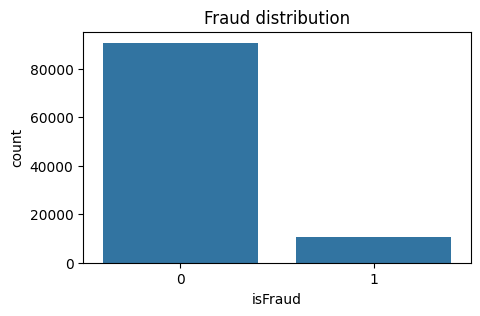

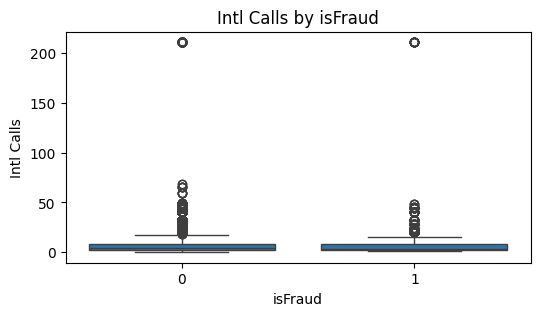

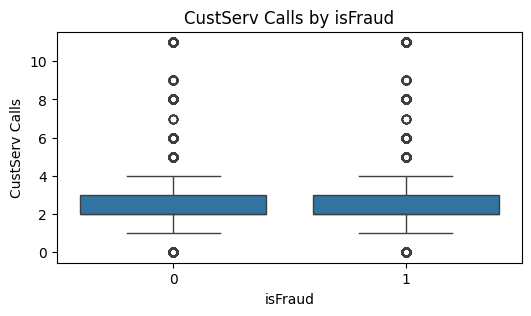

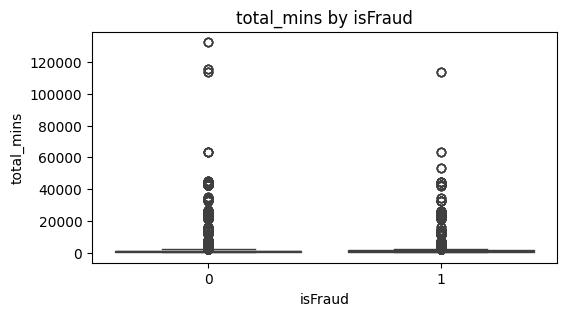

In [15]:
plt.figure(figsize=(5,3))
sns.countplot(x='isFraud', data=df)
plt.title('Fraud distribution')
plt.show()

for col in ['Intl Calls','CustServ Calls','total_mins']:
    if col in df.columns:
        plt.figure(figsize=(6,3))
        sns.boxplot(x='isFraud', y=col, data=df)
        plt.title(f'{col} by isFraud')
        plt.show()


split, scale, SMOTE

In [16]:
X = df[features].copy()
y = df['isFraud'].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

sm = SMOTE(random_state=RANDOM_STATE)
X_train_bal, y_train_bal = sm.fit_resample(X_train_s, y_train)

print("Train before SMOTE:", y_train.value_counts().to_dict())
print("Train after SMOTE:", pd.Series(y_train_bal).value_counts().to_dict())


Train before SMOTE: {0: 67981, 1: 7899}
Train after SMOTE: {0: 67981, 1: 67981}


train baseline models

In [17]:
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE)

rf.fit(X_train_bal, y_train_bal)
xgb.fit(X_train_bal, y_train_bal)

models = {'RandomForest': rf, 'XGBoost': xgb}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [07:15:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


evaluate both

In [18]:
def eval_model(m, Xs, ys):
    yp = m.predict(Xs)
    yprob = m.predict_proba(Xs)[:,1] if hasattr(m, 'predict_proba') else None
    print(classification_report(ys, yp, digits=4))
    print("Confusion:\n", confusion_matrix(ys, yp))
    if yprob is not None:
        print("ROC-AUC:", round(roc_auc_score(ys, yprob),4))
    return yp, yprob

results = {}
for name, model in models.items():
    print("\n===", name, "===")
    yp, yprob = eval_model(model, X_test_s, y_test)
    results[name] = {'model': model, 'yp': yp, 'yprob': yprob}



=== RandomForest ===
              precision    recall  f1-score   support

           0     0.9834    0.9790    0.9812     22661
           1     0.8259    0.8576    0.8414      2633

    accuracy                         0.9664     25294
   macro avg     0.9046    0.9183    0.9113     25294
weighted avg     0.9670    0.9664    0.9666     25294

Confusion:
 [[22185   476]
 [  375  2258]]
ROC-AUC: 0.9718

=== XGBoost ===
              precision    recall  f1-score   support

           0     0.9830    0.9503    0.9664     22661
           1     0.6676    0.8587    0.7512      2633

    accuracy                         0.9408     25294
   macro avg     0.8253    0.9045    0.8588     25294
weighted avg     0.9502    0.9408    0.9440     25294

Confusion:
 [[21535  1126]
 [  372  2261]]
ROC-AUC: 0.9575


quick custom tuning (tune n_estimators quickly)

In [19]:
from sklearn.metrics import f1_score

best_n = None
best_score = 0
for n in [50,100,150,200]:
    rf_tmp = RandomForestClassifier(n_estimators=n, random_state=RANDOM_STATE, n_jobs=-1)
    rf_tmp.fit(X_train_bal, y_train_bal)
    p = rf_tmp.predict(X_test_s)
    f1 = f1_score(y_test, p, pos_label=1)
    print("n_estimators=",n,"-> f1=", round(f1,4))
    if f1 > best_score:
        best_score = f1
        best_n = n

print("Best n_estimators:", best_n, "with f1:", best_score)
best_rf = RandomForestClassifier(n_estimators=best_n, random_state=RANDOM_STATE, n_jobs=-1)
best_rf.fit(X_train_bal, y_train_bal)


n_estimators= 50 -> f1= 0.8358
n_estimators= 100 -> f1= 0.8387
n_estimators= 150 -> f1= 0.8398
n_estimators= 200 -> f1= 0.8414
Best n_estimators: 200 with f1: 0.8414384199739147


RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

evaluate tuned model, PR curve, thresholds

Final tuned RF report:
              precision    recall  f1-score   support

           0     0.9834    0.9790    0.9812     22661
           1     0.8259    0.8576    0.8414      2633

    accuracy                         0.9664     25294
   macro avg     0.9046    0.9183    0.9113     25294
weighted avg     0.9670    0.9664    0.9666     25294

Confusion matrix:
 [[22185   476]
 [  375  2258]]
ROC-AUC: 0.9717812431593635
PR-AUC: 0.8656


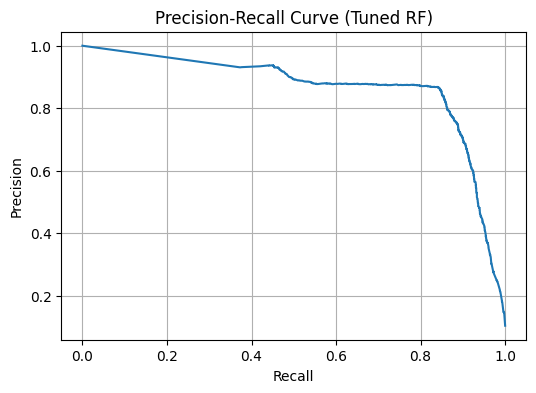

th=0.20 prec 0.607 rec 0.921 f1 0.732
th=0.30 prec 0.69 rec 0.903 f1 0.782
th=0.40 prec 0.777 rec 0.873 f1 0.822
th=0.50 prec 0.826 rec 0.858 f1 0.841


In [20]:
y_pred_best = best_rf.predict(X_test_s)
y_proba_best = best_rf.predict_proba(X_test_s)[:,1]

print("Final tuned RF report:")
print(classification_report(y_test, y_pred_best, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_best))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_best))

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_best)
pr_auc = auc(recall, precision)
print("PR-AUC:", round(pr_auc,4))

plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Tuned RF)")
plt.grid(True)
plt.show()

for t in [0.2,0.3,0.4,0.5]:
    preds_t = (y_proba_best >= t).astype(int)
    print(f"th={t:.2f}", "prec", round(precision_score(y_test, preds_t),3),
          "rec", round(recall_score(y_test, preds_t),3),
          "f1", round(f1_score(y_test, preds_t),3))


feature importance (if tree)

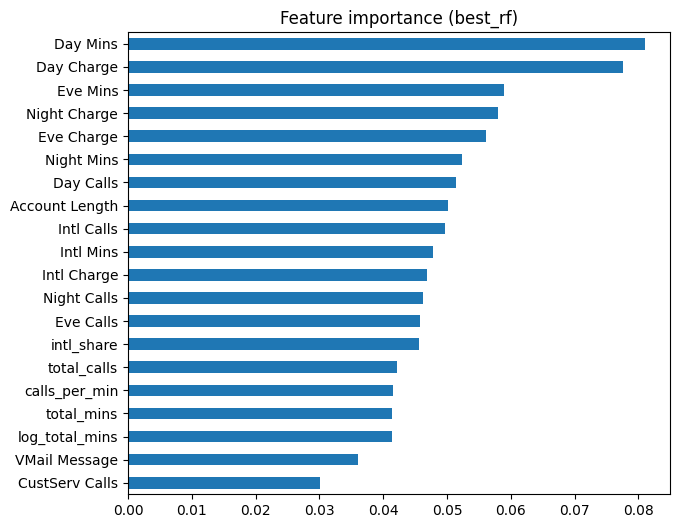

In [21]:
if hasattr(best_rf, 'feature_importances_'):
    fi = pd.Series(best_rf.feature_importances_, index=features).sort_values()
    plt.figure(figsize=(7,6))
    fi.plot(kind='barh')
    plt.title('Feature importance (best_rf)')
    plt.show()


save model & scaler

In [22]:
out_dir = '/mnt/data/call_fraud_project_artifacts'
os.makedirs(out_dir, exist_ok=True)
joblib.dump(best_rf, os.path.join(out_dir, 'best_model.pkl'))
joblib.dump(scaler, os.path.join(out_dir, 'scaler.pkl'))
print("Saved artifacts to:", out_dir)


Saved artifacts to: /mnt/data/call_fraud_project_artifacts


offline single-sample prediction (no warning)

In [23]:
# Pick a real row from X_test (keeps column names)
sample_df = X_test.iloc[[0]].copy()   # double brackets keep DataFrame
sample_scaled = scaler.transform(sample_df)
pred = best_rf.predict(sample_scaled)[0]
prob = best_rf.predict_proba(sample_scaled)[0][1]
print("Prediction:", pred, "| Prob:", round(float(prob),4))


Prediction: 0 | Prob: 0.0
